In [1]:
import trenchripper as tr

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('./deaton.mplstyle')

### Load Functions

In [2]:
def lookup_variant(variant_library_path,channel,varid,trench_indices):
    path_prefix = variant_library_path + "/" + str(varid) + "_"
    variant_files = glob.glob(path_prefix + '*')
    n_files = len(variant_files)
    img_arr = []
    for i in range(n_files):
        variant_file = path_prefix + str(i) + ".hdf5"
        with h5py.File(variant_file,"r") as infile:
            data = infile[channel][trench_indices]
            img_arr.append(data)
    img_arr = np.concatenate(img_arr,axis=1)
    return img_arr

def get_magenta_green_overlay(green_arr,mag_arr,green_arr_min,green_arr_max,mag_arr_min,\
                              mag_arr_max,mag_weight=1.,green_weight=1.):
    
    # Expand dimensions to make them 3D arrays
    image1 = np.expand_dims(green_arr, axis=-1)
    image2 = np.expand_dims(mag_arr, axis=-1)
    
    # Make image1 green
    img_green = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint16)
    img_green[:, :, 1] = image1[:,:,0]
    
    # Make image2 magenta
    img_magenta = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint16)
    img_magenta[:, :, 0] = image2[:,:,0]
    img_magenta[:, :, 2] = image2[:,:,0]
    
    # # Apply contrast to the green channel
    img_green[:, :, 1] = sk.exposure.rescale_intensity(np.clip(img_green[:, :, 1],green_arr_min,green_arr_max)).astype('uint16')
    
    # Apply contrast to the magenta channel
    img_magenta[:, :, 0] = sk.exposure.rescale_intensity(np.clip(img_magenta[:, :, 0],mag_arr_min,mag_arr_max)).astype('uint16')
    img_magenta[:, :, 2] = sk.exposure.rescale_intensity(np.clip(img_magenta[:, :, 2],mag_arr_min,mag_arr_max)).astype('uint16')
    
    merged_image = ((img_green*green_weight)+(img_magenta*mag_weight)).astype('uint16')
    return merged_image

## Load Data

In [3]:
min_points = 5
pos_slope_thr = 0.2
neg_slope_thr = -0.2

ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]
all_slopes_filtered = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Growth_Length_Slopes.csv",index_col="Gene")

In [4]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Instantaneous Growth Rate: Volume']
prolif_params = []
param_names = [r"Length ($ \mu m $)",r"Volume ($ \mu m^{3} $)"]
param_ranges = [(0.,10.),(0.,2.2)]
param_ticks = [[0,2,4,6,8,10],[0.,1.,2.]]

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

# ##removing controls
ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

filtered_ss_estimators_df = ss_estimators_df[ss_estimators_df["Gene"].isin(all_slopes_filtered.index.tolist())]

## Figure S8B

In [5]:
lipid_non_polar = ['accA','accB','accC','accD','acpP','acpS','fabH','fabD','fabG','fabI','fabB','fabA','fabZ',\
                  'plsB','plsC','cdsA','pssA','psd','pgsA','pgpB']
lipid_non_polar_operons = {"AccB-AccC":("accB","accC"),"FabH-FabD-FabG":("fabH","fabD","fabG"),\
                            "AcpP-FabF":("acpP",)}
lipid_non_polar_operons_inv = {item: key for key,val in lipid_non_polar_operons.items() for item in val}

lipid_estimators_df = ss_estimators_df[ss_estimators_df["Gene"].isin(lipid_non_polar)]
lipid_estimators_df["Gene"] = lipid_estimators_df["Gene"].apply(lambda x: lipid_non_polar_operons_inv[x] if x in lipid_non_polar_operons_inv.keys() else x)
target_gene_list = list(lipid_estimators_df["Gene"].unique())

/tmp/ipykernel_36260/1570097248.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_estimators_df["Gene"] = lipid_estimators_df["Gene"].apply(lambda x: lipid_non_polar_operons_inv[x] if x in lipid_non_polar_operons_inv.keys() else x)


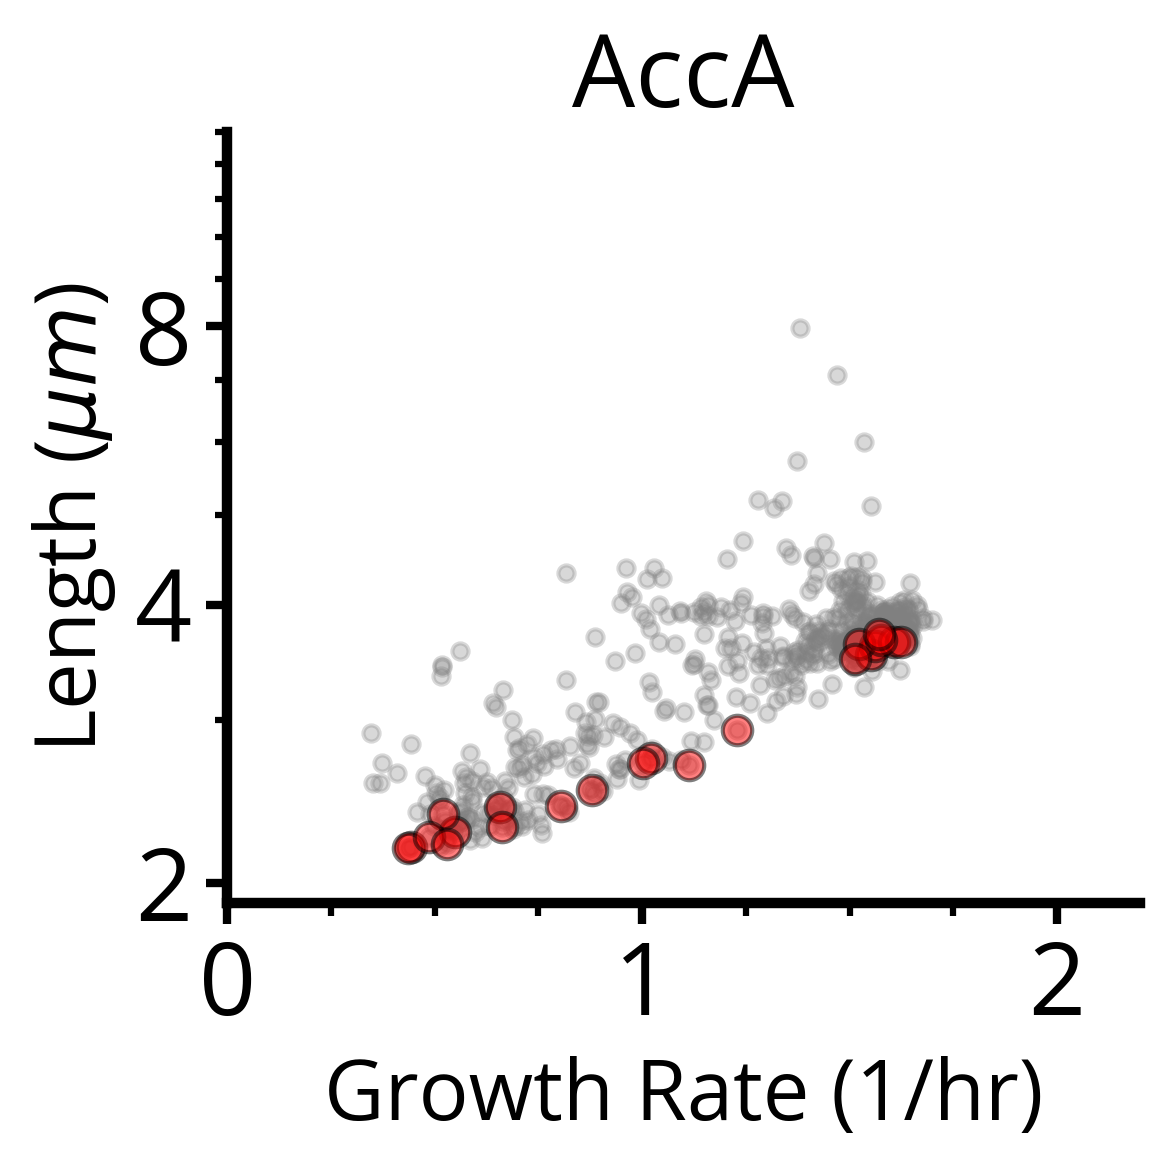

In [6]:
gene_name = "accA"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lipid_estimators_df[lipid_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lipid_estimators_df["Instantaneous Growth Rate: Volume"],lipid_estimators_df["Length"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=20)
ax.set_ylabel(r"Length ($\mu m$)",fontsize=20)

sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + ".png",transparent=True,dpi=300,bbox_inches="tight")

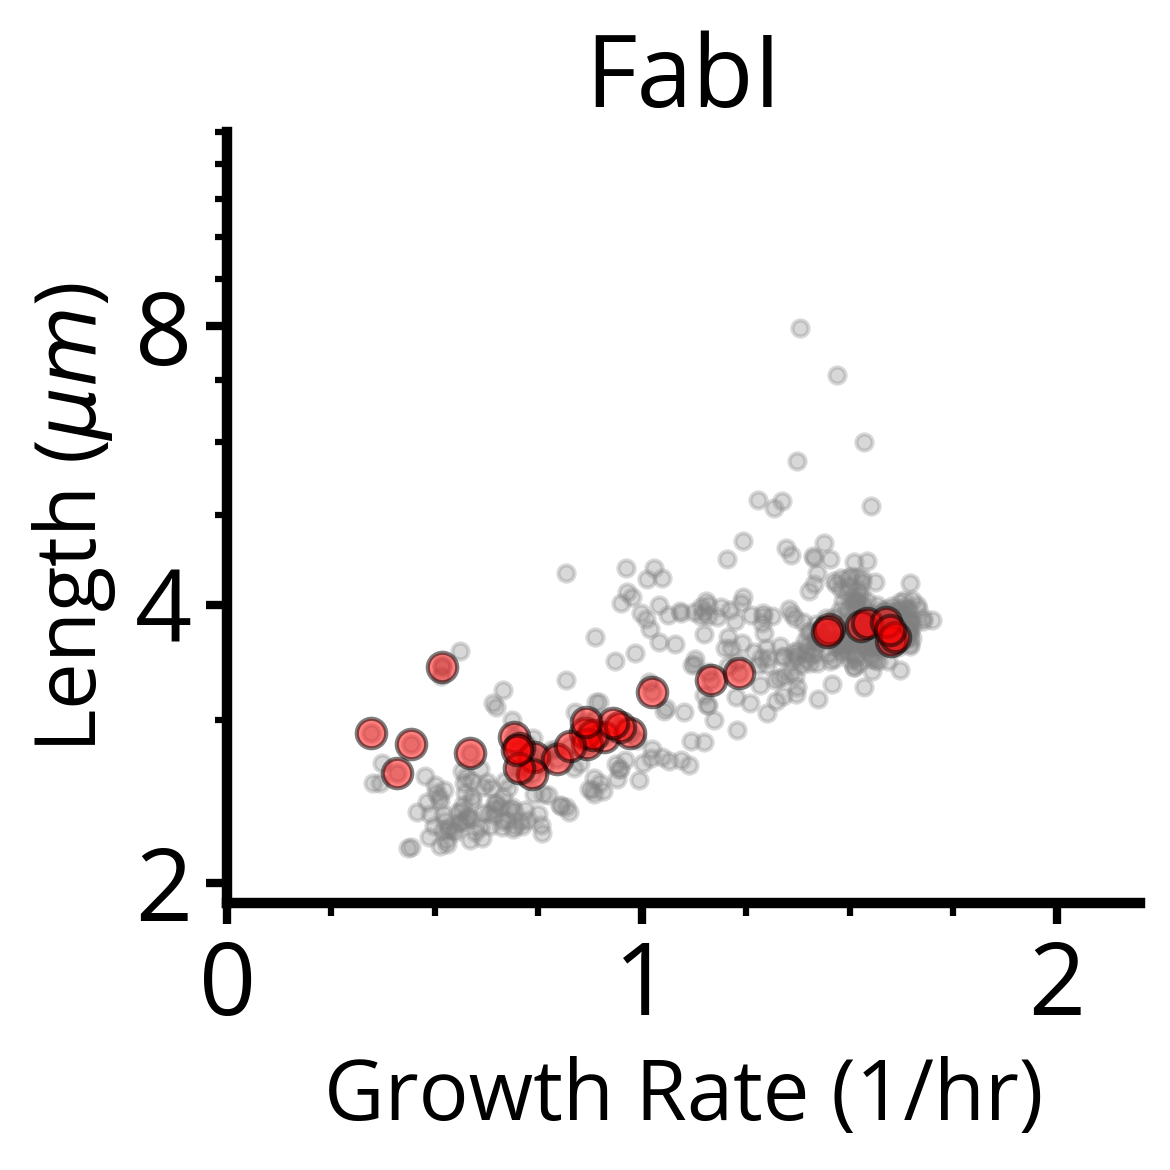

In [7]:
gene_name = "fabI"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lipid_estimators_df[lipid_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lipid_estimators_df["Instantaneous Growth Rate: Volume"],lipid_estimators_df["Length"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=20)
ax.set_ylabel(r"Length ($\mu m$)",fontsize=20)
sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + ".png",transparent=True,dpi=300,bbox_inches="tight")

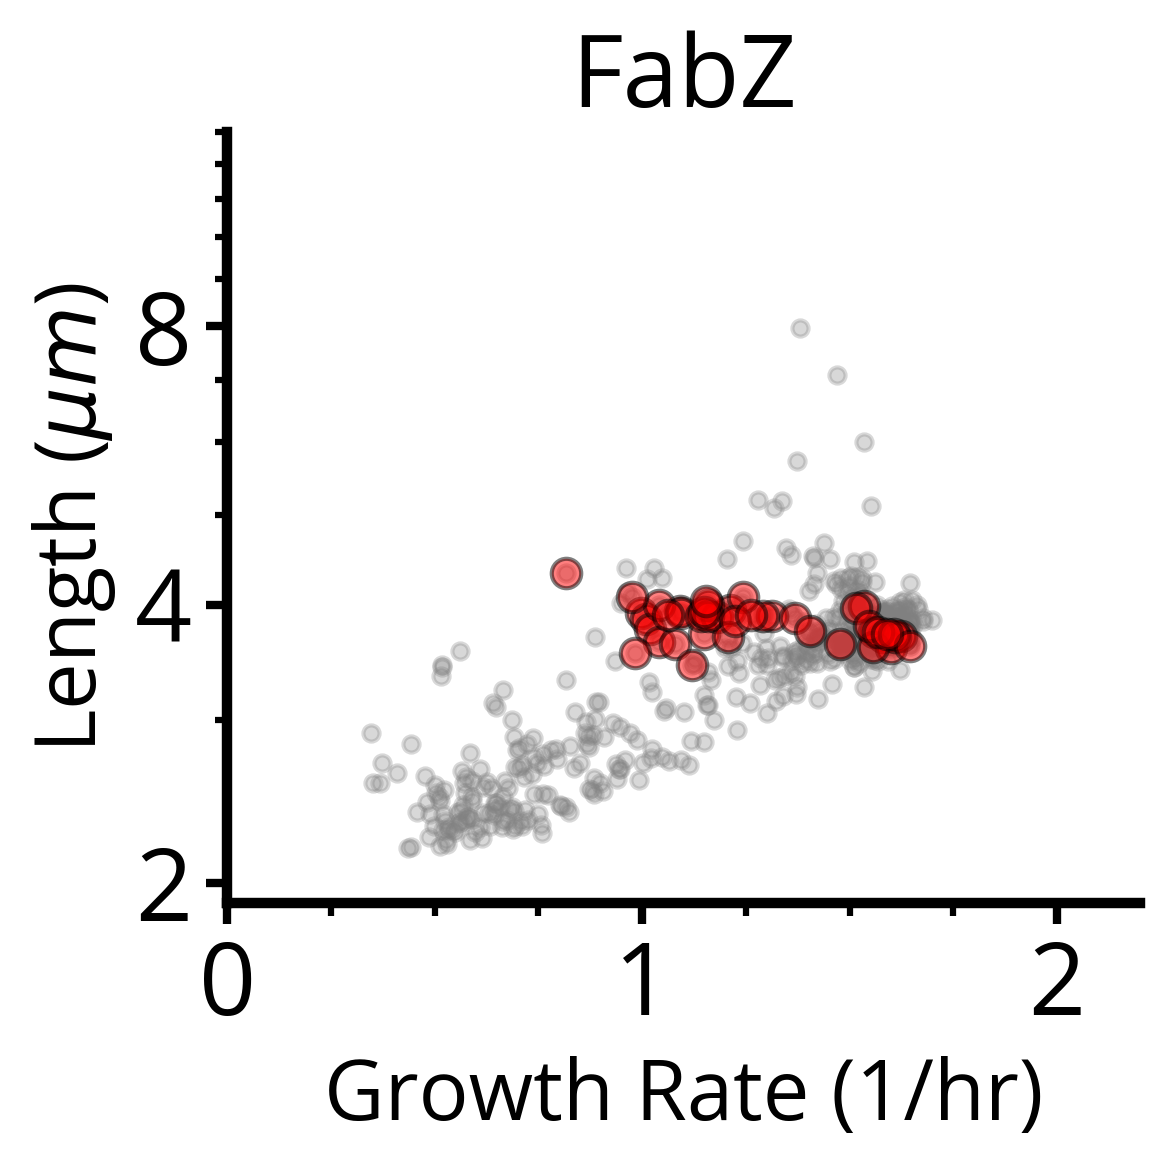

In [8]:
gene_name = "fabZ"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lipid_estimators_df[lipid_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lipid_estimators_df["Instantaneous Growth Rate: Volume"],lipid_estimators_df["Length"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=20)
ax.set_ylabel(r"Length ($\mu m$)",fontsize=20)
sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + ".png",transparent=True,dpi=300,bbox_inches="tight")

## Figure S8C

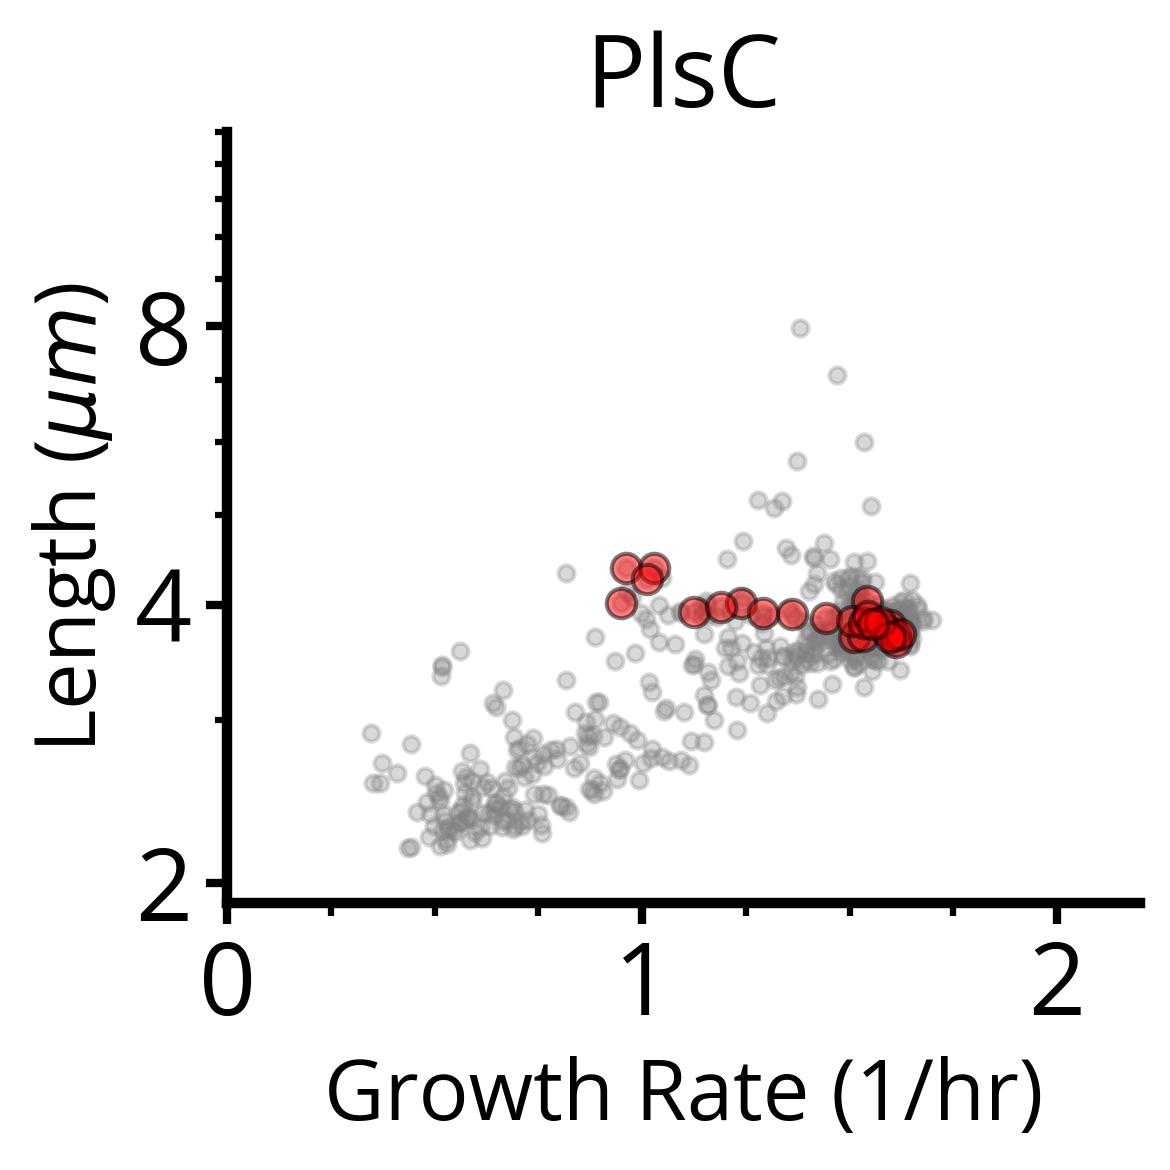

In [9]:
gene_name = "plsC"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lipid_estimators_df[lipid_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lipid_estimators_df["Instantaneous Growth Rate: Volume"],lipid_estimators_df["Length"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=20)
ax.set_ylabel(r"Length ($\mu m$)",fontsize=20)

sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + ".png",transparent=True,dpi=300,bbox_inches="tight")

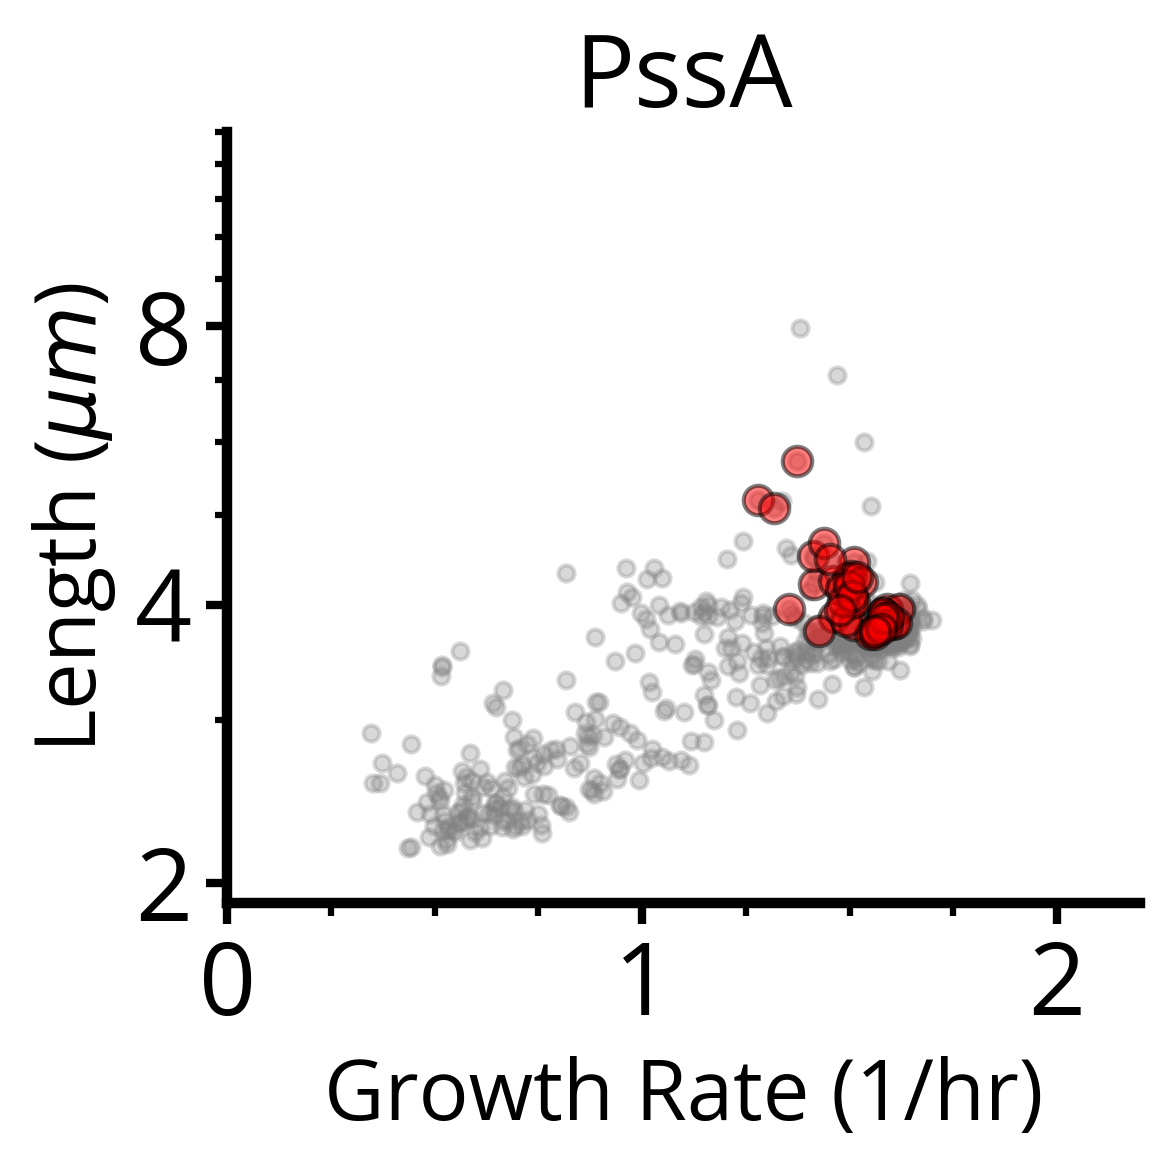

In [10]:
gene_name = "pssA"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lipid_estimators_df[lipid_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lipid_estimators_df["Instantaneous Growth Rate: Volume"],lipid_estimators_df["Length"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=20)
ax.set_ylabel(r"Length ($\mu m$)",fontsize=20)

sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + ".png",transparent=True,dpi=300,bbox_inches="tight")

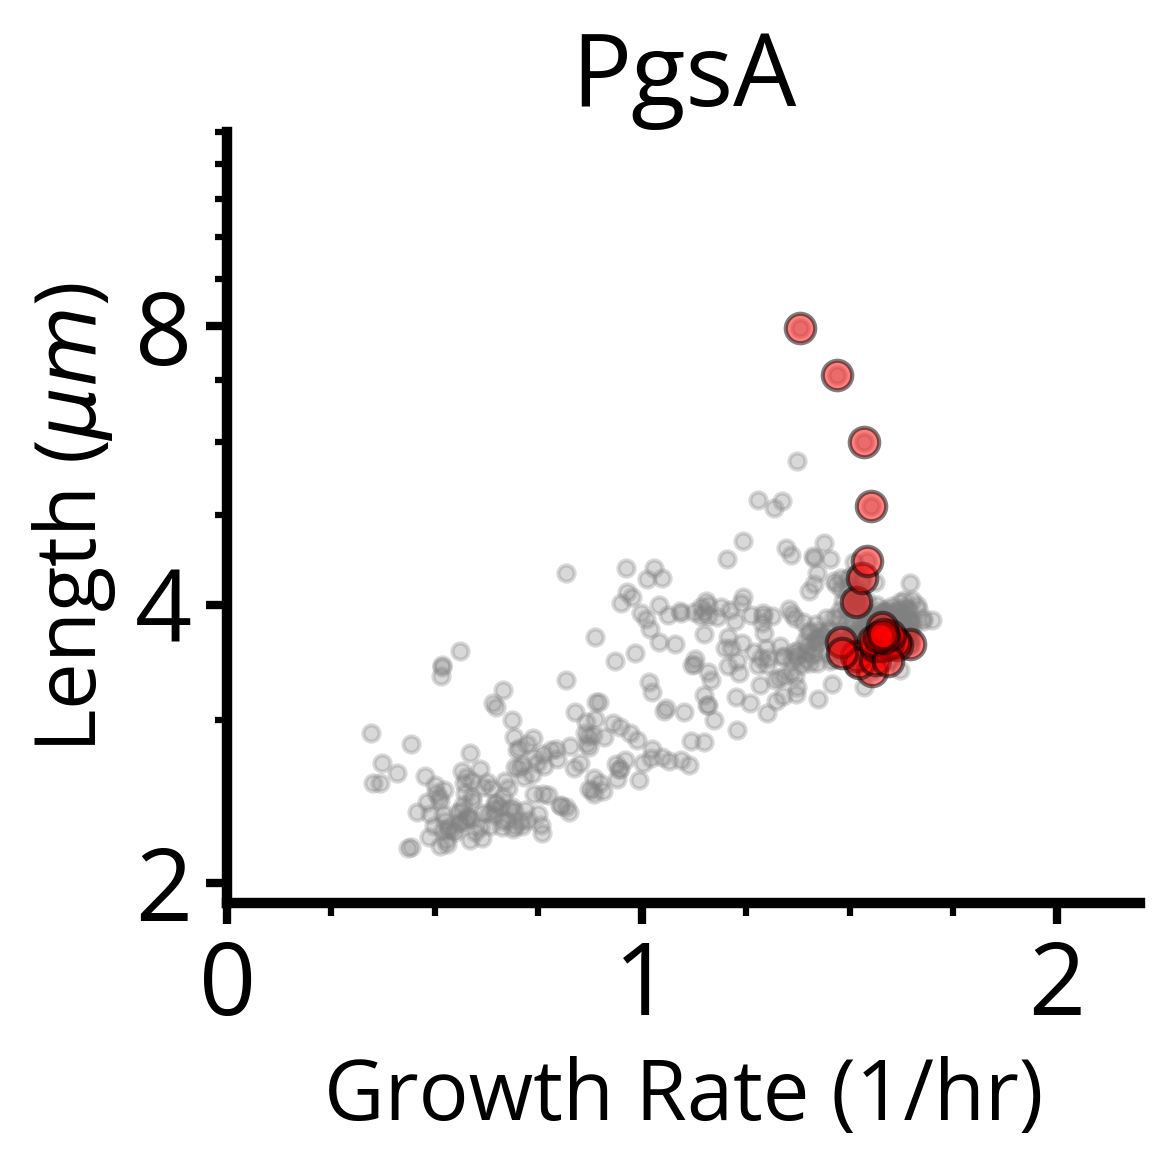

In [11]:
gene_name = "pgsA"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lipid_estimators_df[lipid_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lipid_estimators_df["Instantaneous Growth Rate: Volume"],lipid_estimators_df["Length"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=20)
ax.set_ylabel(r"Length ($\mu m$)",fontsize=20)

sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + ".png",transparent=True,dpi=300,bbox_inches="tight")

## Figure S8D

In [12]:
lpx_pathway = ['lpxA','lpxC','lpxD','lpxH','lpxB','lpxK','waaA','waaC','waaF']
lpx_estimators_df = ss_estimators_df[ss_estimators_df["Gene"].isin(lpx_pathway)]
target_gene_list = list(lpx_estimators_df["Gene"].unique())

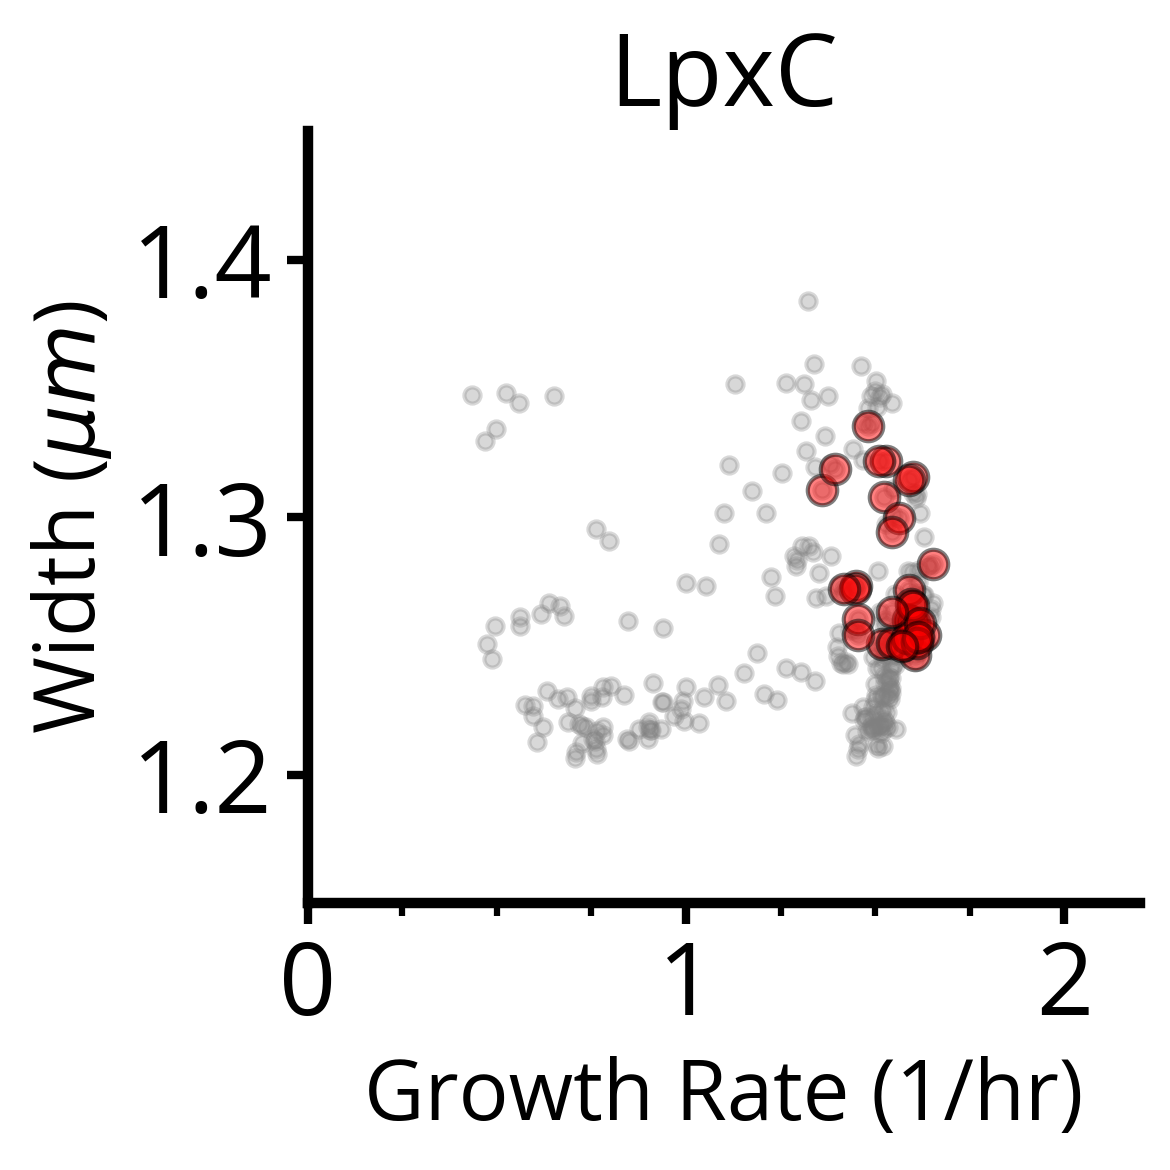

In [13]:
gene_name = "lpxC"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lpx_estimators_df[lpx_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Width"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lpx_estimators_df["Instantaneous Growth Rate: Volume"],lpx_estimators_df["Width"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.15,1.45)

ax.set_yticks(ticks=[1.2,1.3,1.4],labels=["1.2","1.3","1.4"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)

ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=20)
ax.set_ylabel(r"Width ($\mu m$)",fontsize=20)

sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + ".png",transparent=True,dpi=300,bbox_inches="tight")

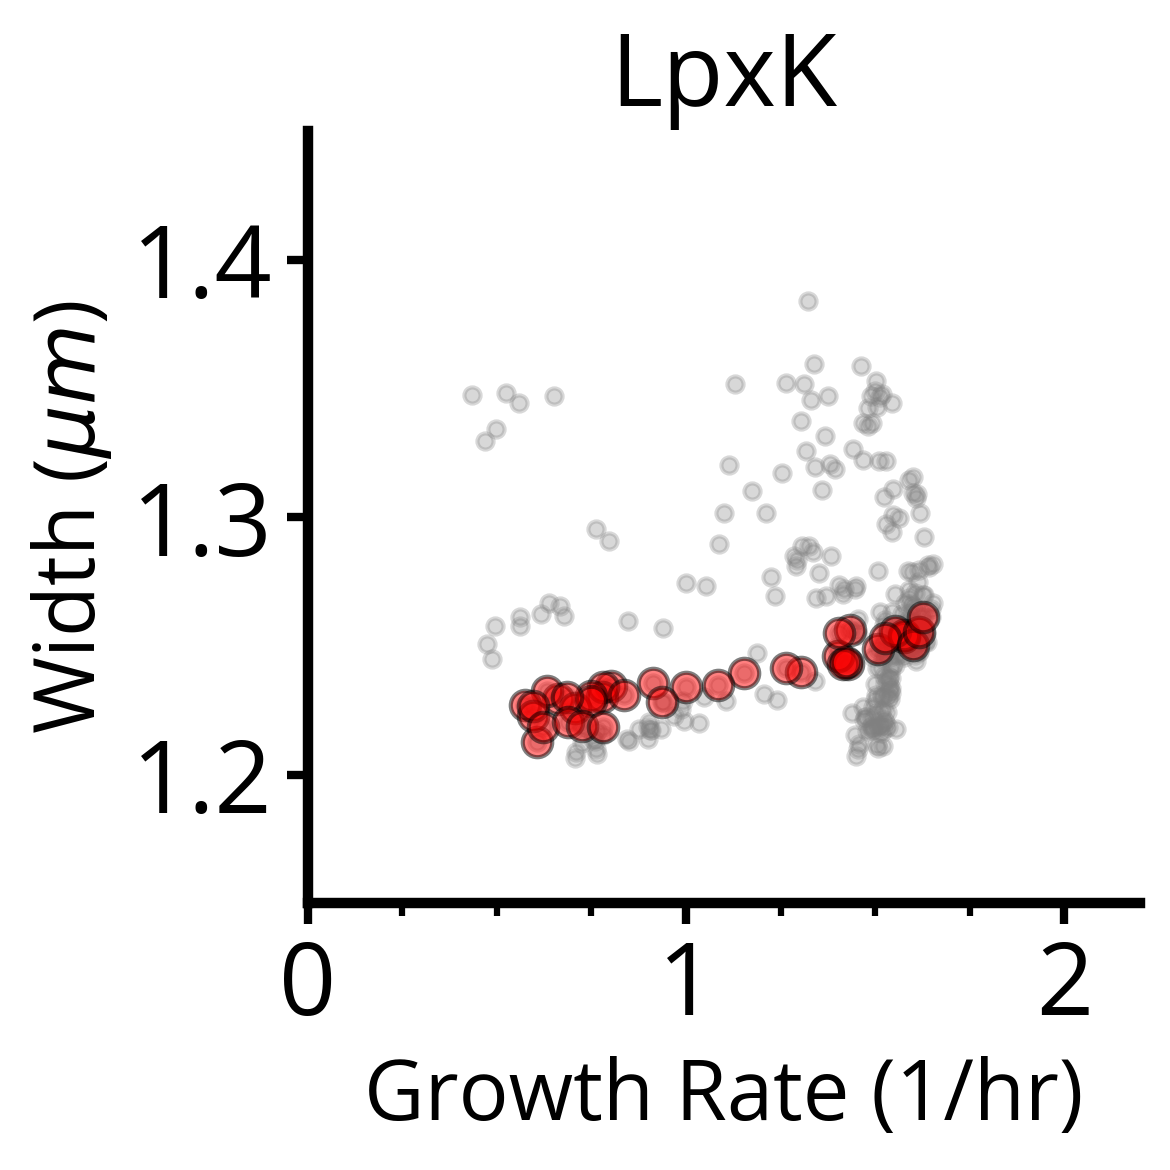

In [14]:
gene_name = "lpxK"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lpx_estimators_df[lpx_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Width"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lpx_estimators_df["Instantaneous Growth Rate: Volume"],lpx_estimators_df["Width"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.15,1.45)

ax.set_yticks(ticks=[1.2,1.3,1.4],labels=["1.2","1.3","1.4"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)

ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=20)
ax.set_ylabel(r"Width ($\mu m$)",fontsize=20)

sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + ".png",transparent=True,dpi=300,bbox_inches="tight")

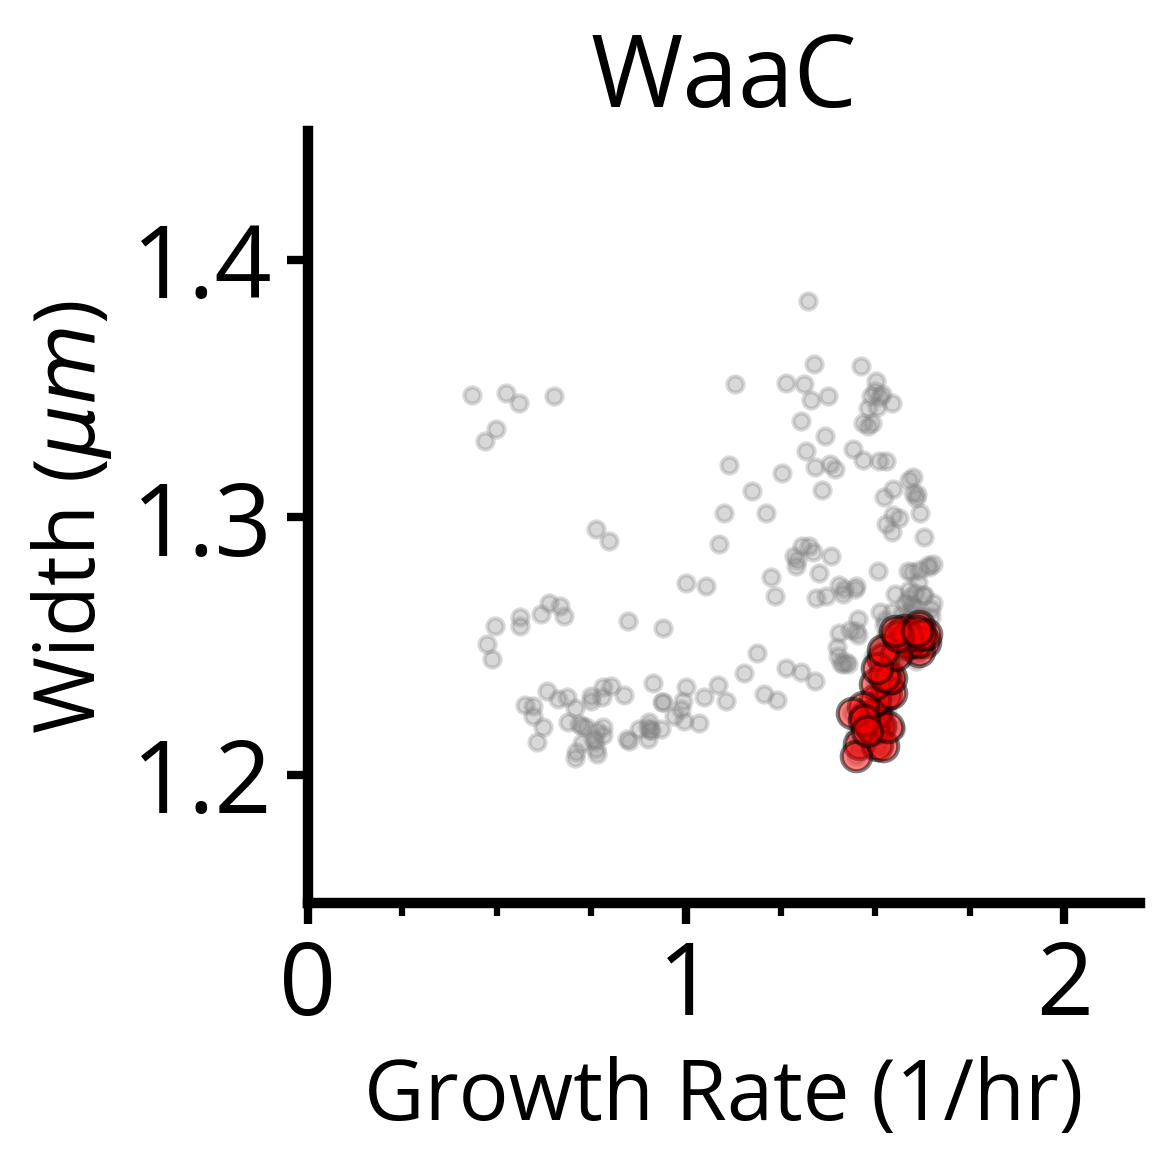

In [15]:
gene_name = "waaC"

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
selected_points = lpx_estimators_df[lpx_estimators_df["Gene"] == gene_name]

xrange = np.linspace(0,2.2)

ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Width"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
ax.scatter(lpx_estimators_df["Instantaneous Growth Rate: Volume"],lpx_estimators_df["Width"],\
           edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
ax.set_xlim(0,2.2)
ax.set_ylim(1.15,1.45)

ax.set_yticks(ticks=[1.2,1.3,1.4],labels=["1.2","1.3","1.4"],minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)

ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=24,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=24)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=20)
ax.set_ylabel(r"Width ($\mu m$)",fontsize=20)

sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/" + gene_name + ".png",transparent=True,dpi=300,bbox_inches="tight")

## Figure S8E

In [5]:
warnings.filterwarnings(action='once',category=UserWarning)

In [6]:
nucleoid_df = pd.read_pickle('/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/2023-04-25_sgRNA_Timeseries_df.pkl')

In [17]:
headpath = "/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1"
variant_library_path = headpath + "/Variant_Library"
base_export_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S8/Kymographs"

## Setting up scale bar
scale_bar_size_um = 6

scalebar_color = 'white'  # Color of the scale bar
scalebar_y_position = 205  # Y-position of the scale bar in data units
scalebar_x_position = 660  # X-position of the scale bar in data units
pixel_microns = 0.106
scale_bar_size_pixels = scale_bar_size_um//pixel_microns

#### minC

In [18]:
gene_name = "minC" 
gene_df = nucleoid_df[nucleoid_df["Gene"] == gene_name]
gene_df["Kernel Trace: Length"].apply(lambda x:x[-1])

oDEPool7_id
12128    6.00367
Name: Kernel Trace: Length, dtype: float64

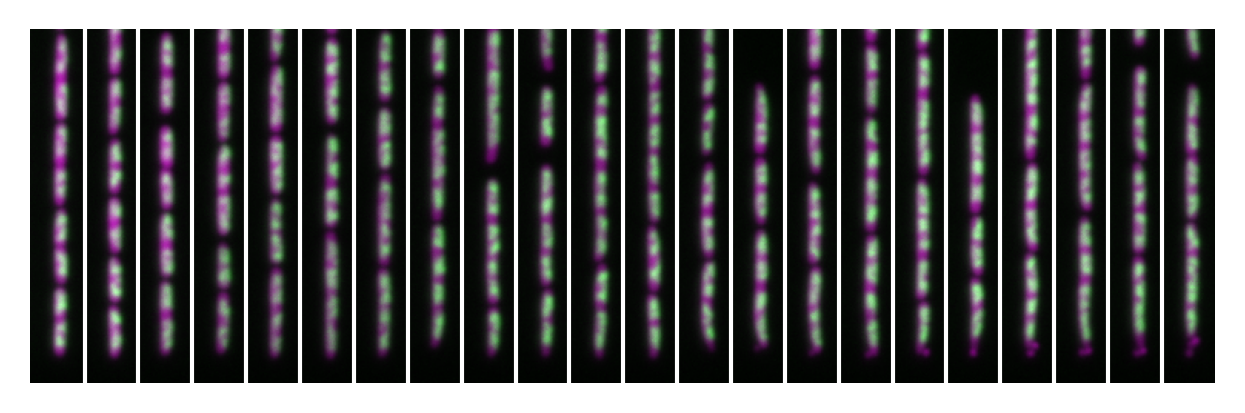

In [19]:
# sgrna index
sgrnaid = 12128
# fetch trench
trenchidx = 1

# time definition
t_step = 2
# t_step = 1
t_i = 18
cropx = 1

min_intensity_green = 0
max_intensity_green = 15000

min_intensity_magenta = 0
max_intensity_magenta = 50000
magenta_weight = 0.8
green_weight = 1

scalebar_on = False
genename_on = False

tr.writedir(base_export_path,overwrite=False)
data = lookup_variant(variant_library_path,"YFP",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
nuc_data = lookup_variant(variant_library_path,"mCherry",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
seg_data = lookup_variant(variant_library_path,"Segmentation",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]

cyto_output = np.concatenate([data[t] for t in range(data.shape[0])],axis=1)
nuc_output = np.concatenate([nuc_data[t] for t in range(nuc_data.shape[0])],axis=1)

seg_output = []
for t in range(seg_data.shape[0]):
    working_seg_data = seg_data[t]
    working_seg_data[working_seg_data>0] = working_seg_data[working_seg_data>0]+(100*t)
    seg_output.append(working_seg_data)
    
seg_output = np.concatenate(seg_output,axis=1)
seg_output, _, _ = sk.segmentation.relabel_sequential(seg_output)

seg_borders_list = []
for i in range(1,np.max(seg_output)+1):
    seg_borders = sk.measure.find_contours(sk.filters.gaussian(seg_output == i,sigma=3), level=0.5)[0]
    seg_borders_list.append(seg_borders)

merged_image = get_magenta_green_overlay(nuc_output,cyto_output,min_intensity_green,max_intensity_green,\
                                       min_intensity_magenta,max_intensity_magenta,mag_weight=magenta_weight,\
                                        green_weight=green_weight)

# # # np.clip(img_green.astype(np.uint32) + img_magenta.astype(np.uint32), 0, 65535).astype(np.uint16)
plt.imshow(sk.util.img_as_ubyte(merged_image))
# for seg_border in seg_borders_list:
#     plt.plot(seg_border[:,1],seg_border[:,0],color="white",linestyle="--",linewidth=0.75)
plt.ylim(280,50)

if genename_on:
    plt.text(5,
            60,
            f"{gene_name}",
            fontdict={'style': 'italic'},
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=40)
# Add a label next to the scale bar
if scalebar_on:
    # Draw the scale bar
    plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
            [scalebar_y_position, scalebar_y_position],
            color=scalebar_color,
            linewidth=4)
    plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
            scalebar_y_position+15,
            f'{scale_bar_size_um} $\mu m$',
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=18)
plt.vlines([(data.shape[2]*t) for t in range(1,data.shape[0])],-0.5,660.5,linestyle="-",color="white",linewidth=1,zorder=20)
plt.axis('off')
plt.savefig(base_export_path + "/" + gene_name + "_" + str(sgrnaid) + ".png",transparent=True,dpi=500,\
            bbox_inches="tight")

#### lolE

In [20]:
gene_name = "lolE" 
gene_df = nucleoid_df[nucleoid_df["Gene"] == gene_name]
gene_df["Kernel Trace: Length"].apply(lambda x:x[-1])

oDEPool7_id
16303    6.016735
Name: Kernel Trace: Length, dtype: float64

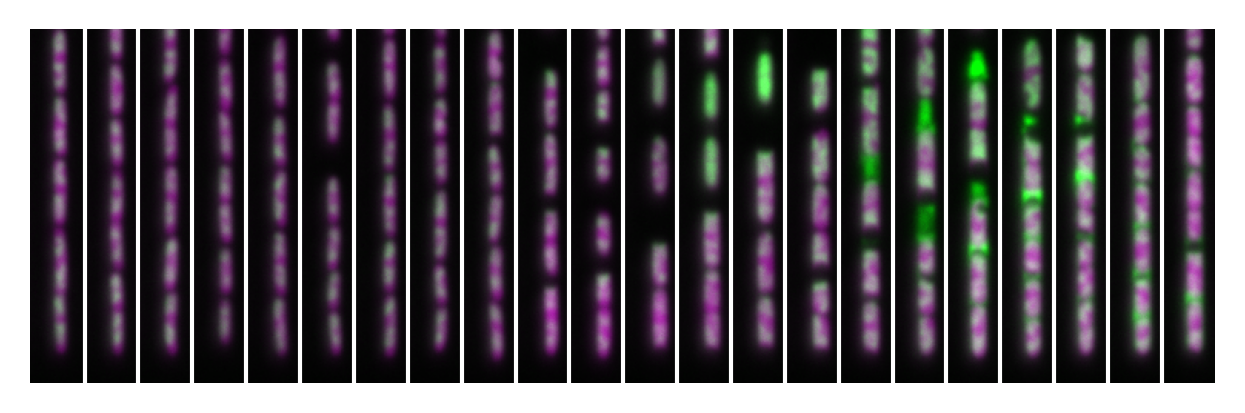

In [21]:
# sgrna index
sgrnaid = 16303
# fetch trench
trenchidx = 4

# time definition
t_step = 2
# t_step = 1
t_i = 18
cropx = 1

min_intensity_green = 0
max_intensity_green = 15000

min_intensity_magenta = 0
max_intensity_magenta = 50000
magenta_weight = 0.8
green_weight = 1

scalebar_on = False
genename_on = False

tr.writedir(base_export_path,overwrite=False)
data = lookup_variant(variant_library_path,"YFP",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
nuc_data = lookup_variant(variant_library_path,"mCherry",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
seg_data = lookup_variant(variant_library_path,"Segmentation",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]

cyto_output = np.concatenate([data[t] for t in range(data.shape[0])],axis=1)
nuc_output = np.concatenate([nuc_data[t] for t in range(nuc_data.shape[0])],axis=1)

seg_output = []
for t in range(seg_data.shape[0]):
    working_seg_data = seg_data[t]
    working_seg_data[working_seg_data>0] = working_seg_data[working_seg_data>0]+(100*t)
    seg_output.append(working_seg_data)
    
seg_output = np.concatenate(seg_output,axis=1)
seg_output, _, _ = sk.segmentation.relabel_sequential(seg_output)

seg_borders_list = []
for i in range(1,np.max(seg_output)+1):
    seg_borders = sk.measure.find_contours(sk.filters.gaussian(seg_output == i,sigma=3), level=0.5)[0]
    seg_borders_list.append(seg_borders)

merged_image = get_magenta_green_overlay(nuc_output,cyto_output,min_intensity_green,max_intensity_green,\
                                       min_intensity_magenta,max_intensity_magenta,mag_weight=magenta_weight,\
                                        green_weight=green_weight)

# # # np.clip(img_green.astype(np.uint32) + img_magenta.astype(np.uint32), 0, 65535).astype(np.uint16)
plt.imshow(sk.util.img_as_ubyte(merged_image))
# for seg_border in seg_borders_list:
#     plt.plot(seg_border[:,1],seg_border[:,0],color="white",linestyle="--",linewidth=0.75)
plt.ylim(280,50)

if genename_on:
    plt.text(5,
            60,
            f"{gene_name}",
            fontdict={'style': 'italic'},
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=40)
# Add a label next to the scale bar
if scalebar_on:
    # Draw the scale bar
    plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
            [scalebar_y_position, scalebar_y_position],
            color=scalebar_color,
            linewidth=4)
    plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
            scalebar_y_position+15,
            f'{scale_bar_size_um} $\mu m$',
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=18)
plt.vlines([(data.shape[2]*t) for t in range(1,data.shape[0])],-0.5,660.5,linestyle="-",color="white",linewidth=1,zorder=20)
plt.axis('off')
plt.savefig(base_export_path + "/" + gene_name + "_" + str(sgrnaid) + ".png",transparent=True,dpi=500,\
            bbox_inches="tight")

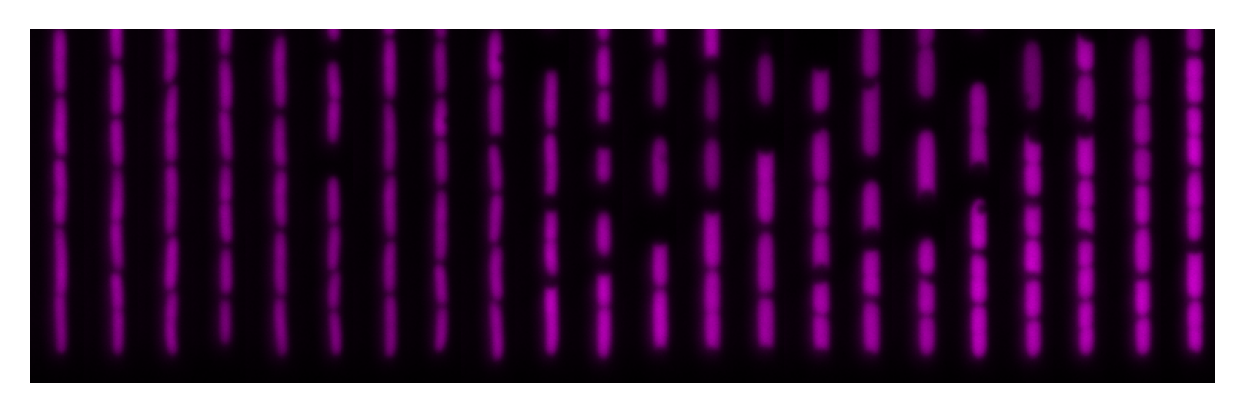

In [22]:
# sgrna index
sgrnaid = 16303
# fetch trench
trenchidx = 4

# time definition
t_step = 2
# t_step = 1
t_i = 18
cropx = 1

min_intensity_green = 0
max_intensity_green = 15000

min_intensity_magenta = 0
max_intensity_magenta = 50000
magenta_weight = 0.8
green_weight = 0

scalebar_on = False
genename_on = False

tr.writedir(base_export_path,overwrite=False)
data = lookup_variant(variant_library_path,"YFP",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
nuc_data = lookup_variant(variant_library_path,"mCherry",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
seg_data = lookup_variant(variant_library_path,"Segmentation",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]

cyto_output = np.concatenate([data[t] for t in range(data.shape[0])],axis=1)
nuc_output = np.concatenate([nuc_data[t] for t in range(nuc_data.shape[0])],axis=1)

seg_output = []
for t in range(seg_data.shape[0]):
    working_seg_data = seg_data[t]
    working_seg_data[working_seg_data>0] = working_seg_data[working_seg_data>0]+(100*t)
    seg_output.append(working_seg_data)
    
seg_output = np.concatenate(seg_output,axis=1)
seg_output, _, _ = sk.segmentation.relabel_sequential(seg_output)

seg_borders_list = []
for i in range(1,np.max(seg_output)+1):
    seg_borders = sk.measure.find_contours(sk.filters.gaussian(seg_output == i,sigma=3), level=0.5)[0]
    seg_borders_list.append(seg_borders)

merged_image = get_magenta_green_overlay(nuc_output,cyto_output,min_intensity_green,max_intensity_green,\
                                       min_intensity_magenta,max_intensity_magenta,mag_weight=magenta_weight,\
                                        green_weight=green_weight)

# # # np.clip(img_green.astype(np.uint32) + img_magenta.astype(np.uint32), 0, 65535).astype(np.uint16)
plt.imshow(sk.util.img_as_ubyte(merged_image))
# for seg_border in seg_borders_list:
#     plt.plot(seg_border[:,1],seg_border[:,0],color="white",linestyle="--",linewidth=0.75)
plt.ylim(280,50)

if genename_on:
    plt.text(5,
            60,
            f"{gene_name}",
            fontdict={'style': 'italic'},
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=40)
# Add a label next to the scale bar
if scalebar_on:
    # Draw the scale bar
    plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
            [scalebar_y_position, scalebar_y_position],
            color=scalebar_color,
            linewidth=4)
    plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
            scalebar_y_position+15,
            f'{scale_bar_size_um} $\mu m$',
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=18)
# plt.vlines([(data.shape[2]*t) for t in range(1,data.shape[0])],-0.5,660.5,linestyle="-",color="white",linewidth=1,zorder=20)
plt.axis('off')
plt.savefig(base_export_path + "/" + gene_name + "_" + str(sgrnaid) + "onlycyto.png",transparent=True,dpi=500,\
            bbox_inches="tight")